In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import regularizers
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

2023-04-01 11:22:17.407798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_csv('/Users/inigoparra/Desktop/data/clean-master.csv')

In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

X_val = val_data['text']
y_val = val_data['label']

In [5]:
with open('/Users/inigoparra/Desktop/GitHub Repositories/WiBaSets/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(filtered_tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

In [7]:
import re
import nltk

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'[0-9]', '', text) 
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.split() 
    text = ' '.join(text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
X_val = X_val.apply(clean_text)

print(X_train[3])

bilduren bozkatu kasko balio irudi txirrindularia kaskoaz nahita


In [8]:
max_features = 20500
max_len = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [9]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Bidirectional(GRU(32, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.02), 
               recurrent_regularizer=regularizers.l2(0.02))))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(16)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2023-04-01 11:22:44.099825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/inigoparra/opt/anaconda3/envs/TF/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
batch_size = 16
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
374/374 [==============================] - 27s 62ms/step - loss: 5.8823 - accuracy: 0.3649 - val_loss: 4.1046 - val_accuracy: 0.3805
Epoch 2/10
374/374 [==============================] - 22s 59ms/step - loss: 3.0872 - accuracy: 0.3907 - val_loss: 2.3136 - val_accuracy: 0.3835
Epoch 3/10
374/374 [==============================] - 23s 61ms/step - loss: 1.8854 - accuracy: 0.3964 - val_loss: 1.5706 - val_accuracy: 0.3774
Epoch 4/10
374/374 [==============================] - 22s 58ms/step - loss: 1.3984 - accuracy: 0.4106 - val_loss: 1.2806 - val_accuracy: 0.3835
Epoch 5/10
374/374 [==============================] - 22s 58ms/step - loss: 1.1991 - accuracy: 0.4360 - val_loss: 1.1717 - val_accuracy: 0.3820
Epoch 6/10
374/374 [==============================] - 22s 59ms/step - loss: 1.0398 - accuracy: 0.5781 - val_loss: 1.1953 - val_accuracy: 0.3955
Epoch 7/10
374/374 [==============================] - 22s 59ms/step - loss: 0.8621 - accuracy: 0.6887 - val_loss: 1.2675 - val_accuracy:

In [11]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

24/24 [==============================] - 0s 15ms/step - loss: 1.6167 - accuracy: 0.4168
Test loss: 1.6167489290237427, Test accuracy: 0.41677942872047424


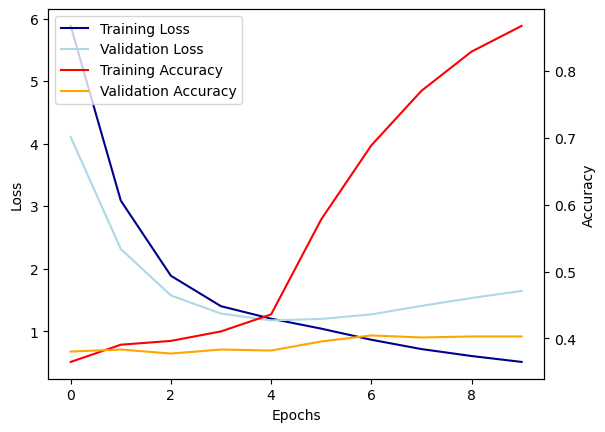

In [12]:
import matplotlib.pyplot as plt

# Get the training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss', color='darkblue')
plt.plot(val_loss, label='Validation Loss', color='lightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot the training and validation accuracy curves
plt.twinx()  # Create a second y-axis that shares the same x-axis
plt.plot(train_acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylabel('Accuracy')

handles, labels = [], []
for ax in plt.gcf().axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles, labels)

plt.show()

21/21 [==============================] - 1s 15ms/step


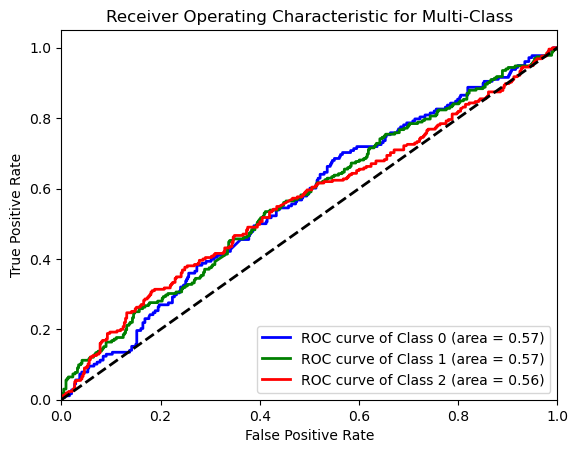

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_train_onehot = label_binarize(y_train, classes=[0, 1, 2])
y_val_onehot = label_binarize(y_val, classes=[0, 1, 2])
y_pred_proba = model.predict(X_val_pad)
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves in the same plot with different colors
plt.figure()
colors = ['blue', 'green', 'red']
class_labels = ['Class 0', 'Class 1', 'Class 2']
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

